In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Labels

In [3]:
labels_df = pd.read_csv('data/secom_labels.data', sep=' ', header = None)
labels_df.columns = ['Label', 'Date']
labels_df['Date'] = pd.to_datetime(labels_df['Date'], format = "%d/%m/%Y %H:%M:%S")
print('labels_df shape = {}'.format(labels_df.shape))
labels_df.head()

labels_df shape = (1567, 2)


,Label,Date
0,-1,2008-07-19 11:55:00
1,-1,2008-07-19 12:32:00
2,1,2008-07-19 13:17:00
3,-1,2008-07-19 14:43:00
4,-1,2008-07-19 15:22:00


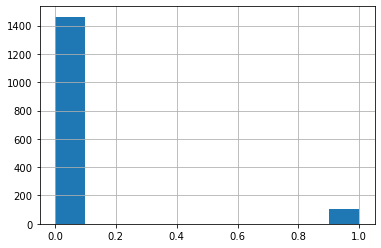

In [4]:
labels_df['Label'] = labels_df['Label'].apply(lambda x: 0 if x == -1 else 1)
labels_df['Label'].hist()

In [5]:
label_sum = labels_df['Label'].groupby(labels_df['Date'].dt.date).sum().reset_index()
label_count = labels_df['Label'].groupby(labels_df['Date'].dt.date).count().reset_index()
label_day = pd.merge(label_sum, label_count, on='Date')
label_day.columns = ['Date', 'Sum', 'Count']
label_day['Date'] = pd.to_datetime(label_day['Date'])
label_day.head()

,Date,Sum,Count
0,2008-07-19,3,12
1,2008-07-20,0,1
2,2008-07-21,1,2
3,2008-07-22,0,6
4,2008-07-23,0,2


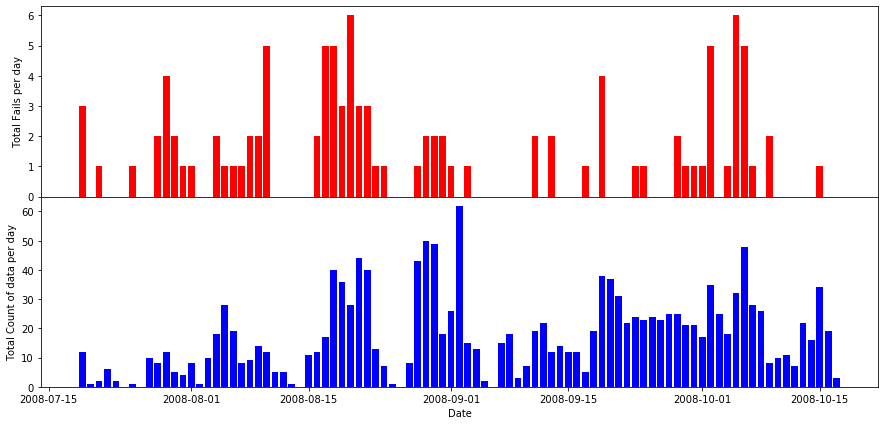

In [6]:
# Create a figure with shared X axis
fig, axs = plt.subplots(2, 1, sharex=True, figsize = (15,7))

# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)

# Set the width of the bars to be 1 day
#width = np.timedelta64(1, 'D')

# Plot the Sum of fails per day and count of entries per day
axs[0].bar(label_day['Date'], label_day['Sum'], color = 'red')
axs[1].bar(label_day['Date'], label_day['Count'], color = 'blue')
axs[0].set_ylabel('Total Fails per day')
axs[1].set_ylabel('Total Count of data per day')
axs[1].set_xlabel('Date');

In [7]:
# Data

In [8]:
data_df = pd.read_csv('data/secom.data', sep=' ', header = None)
print('data_df shape = {}'.format(data_df.shape))
data_df.columns = ['x_{}'.format(i) for i in range (0,590)]
data_df.head()

data_df shape = (1567, 590)


,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_580,x_581,x_582,x_583,x_584,x_585,x_586,x_587,x_588,x_589
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


In [9]:
# Merging Data and Labels

In [10]:
merged_df = data_df.merge(labels_df, left_index=True, right_index=True)
print(merged_df.shape)
merged_df.head()

(1567, 592)


,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_582,x_583,x_584,x_585,x_586,x_587,x_588,x_589,Label,Date
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,0,2008-07-19 11:55:00
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,0,2008-07-19 12:32:00
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1,2008-07-19 13:17:00
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,0,2008-07-19 14:43:00
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,0,2008-07-19 15:22:00


In [11]:
# Split Train and Test based on date

In [12]:
split_date = '2008-10-01'
train_df = merged_df[merged_df['Date'] < split_date]
test_df = merged_df[merged_df['Date'] >= split_date]
print('train df shape: {}, test df shape: {}'.format(train_df.shape, test_df.shape))

train df shape: (1208, 592), test df shape: (359, 592)


Strategy
1. Test for univariate correlation and remove those columns with no correlation to label (chi square)
2. Find outliers using Isolation forest and add as a new feature
3. Feature scaling
4. Downsample 100 times and build a model each time.
5. Final prediction is ensemble of all models

In [13]:
# Train data univariate correlation
from scipy.stats import pearsonr

In [14]:
pearson_pvalues = []
for col in train_df.columns[:-2]:
    df_clean = train_df[[col, 'Label']].dropna()
    pearson_corr, pearson_pvalue = pearsonr(df_clean[col], df_clean['Label'])
    pearson_pvalues.append(pearson_pvalue)

In [15]:
sig_colidx = [i for i, n in enumerate(pearson_pvalues) if n <= 0.05]
sig_colidx.extend([-2, -1])

In [16]:
train_df_red_dim = train_df.iloc[:, sig_colidx]
test_df_red_dim = test_df.iloc[:, sig_colidx]
print('train df shape: {}, test df shape: {}'.format(train_df_red_dim.shape, test_df_red_dim.shape))
train_df_red_dim.head()

train df shape: (1208, 83), test df shape: (359, 83)


,x_0,x_14,x_21,x_22,x_26,x_28,x_30,x_33,x_59,x_63,...,x_551,x_553,x_554,x_556,x_557,x_562,x_587,x_588,Label,Date
0,3030.93,7.9558,-5419.00,2916.50,1.7730,64.2333,0.1632,9.5126,-1.7264,16.1445,...,0.78,5.7349,0.3363,3.2687,1.0297,NaN,NaN,NaN,0,2008-07-19 11:55:00
1,3095.78,10.1548,-5441.50,2604.25,2.0143,68.4222,0.2102,9.7997,0.8073,10.9036,...,1.33,7.1196,0.4989,3.9139,1.7819,NaN,0.0201,0.0060,0,2008-07-19 12:32:00
2,2932.61,9.5157,-5447.75,2701.75,2.0295,67.1333,0.1734,8.6590,23.8245,11.3019,...,0.85,7.1619,0.3752,3.9306,1.1386,267.064,0.0484,0.0148,1,2008-07-19 13:17:00
3,2988.72,9.6052,-5468.25,2648.25,2.0038,62.9333,0.2071,8.6789,24.3791,13.5597,...,39.33,56.9303,17.4781,35.3198,54.2917,268.228,0.0149,0.0044,0,2008-07-19 14:43:00
4,3032.24,10.5661,-5476.25,2635.25,1.9912,62.8333,0.2696,8.7677,-12.2945,21.9782,...,1.98,9.7608,0.8311,4.9086,2.5014,NaN,0.0149,0.0044,0,2008-07-19 15:22:00


In [17]:
# Split features (X) and response (y)
X_train = train_df_red_dim.iloc[:,:-2].reset_index(drop=True)
y_train = train_df_red_dim.iloc[:,-2].reset_index(drop=True)
X_test = test_df_red_dim.iloc[:,:-2].reset_index(drop=True)
y_test = test_df_red_dim.iloc[:,-2].reset_index(drop=True)

In [18]:
# Imputation
from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy='mean')
imp = imp.fit(X_train)

X_train_imp = imp.transform(X_train)
X_test_imp = imp.transform(X_test)

In [19]:
# Outlier detection
from sklearn.ensemble import IsolationForest

# Train the model on training dataset with label == 0
clf = IsolationForest(random_state=1)
clf.fit(X_train_imp[y_train[y_train == 0].index])

# predictions
train_outliers = clf.predict(X_train_imp)
test_outliers = clf.predict(X_test_imp)

C:\Users\msleo\anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
C:\Users\msleo\anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


In [20]:
# Add outlier prediction as a feature column
X_train_imp_append = np.column_stack((X_train_imp, train_outliers))
X_test_imp_append = np.column_stack((X_test_imp, test_outliers))

In [61]:
# train_non_outliers_idx = [i for i, n in enumerate(train_outliers) if n > 0]
# test_non_outliers_idx = [i for i, n in enumerate(test_outliers) if n > 0]
# X_train_out = X_train_imp[train_non_outliers_idx]
# y_train_out = y_train[train_non_outliers_idx]
# X_test_out = X_train_imp[test_non_outliers_idx]
# y_test_out = y_test[test_non_outliers_idx]

In [ ]:
# Scaling

In [26]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train_imp_append)
X_train_imp_append_scaled = scaler.transform(X_train_imp_append)
X_test_imp_append_scaled = scaler.transform(X_test_imp_append)

In [28]:
# Downsample 100 times
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier

C:\Users\msleo\anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [35]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [2, 5, 10],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [10, 20, 30]
}
n = 5
clf_list = []
for i in range(n):
    ros = RandomUnderSampler(random_state=i)
    X_train_sam, y_train_sam = ros.fit_sample(X_train_imp_append_scaled, y_train)
    
    clf = RandomForestClassifier(random_state=i)
    grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2, iid=True)  
    clf_list.append(grid_search.fit(X_train_sam, y_train_sam))

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:    6.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:    6.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Done 106 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:    6.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:    9.0s finished


In [36]:
y_pred_train_list = []
y_pred_test_list = []
for clf in clf_list:
    print('best params: {}\n'.format(clf.best_params_))
    y_pred_train = clf.predict(X_train_imp_append_scaled)
    y_pred_train_list.append(y_pred_train)
    
    y_pred_test = clf.predict(X_test_imp_append_scaled)
    y_pred_test_list.append(y_pred_test)

best params: {'max_depth': 5, 'max_features': 2, 'min_samples_leaf': 5, 'min_samples_split': 8, 'n_estimators': 20}

best params: {'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 8, 'n_estimators': 10}

best params: {'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 30}

best params: {'max_depth': 10, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 20}

best params: {'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 20}



In [37]:
y_pred_list = np.array(y_pred_train_list)
y_pred_train_ = np.mean(y_pred_list, axis=0)
y_pred_train = [0 if x < 0.5 else 1 for x in y_pred_train_]

y_pred_list = np.array(y_pred_test_list)
y_pred_test_ = np.mean(y_pred_list, axis=0)
y_pred_test = [0 if x < 0.5 else 1 for x in y_pred_test_]

In [38]:
from sklearn import metrics
name = 'Downsampled Classifier'
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_train)
precision = metrics.precision_score(y_train, y_pred_train)
recall = metrics.recall_score(y_train, y_pred_train)
print('{} train AUC: {:0.2f}'.format(name, metrics.auc(fpr, tpr)))
print('Train Precision: {:0.2f}. Train Recall: {:0.2f}\n'.format(precision, recall))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_test)
precision = metrics.precision_score(y_test, y_pred_test)
recall = metrics.recall_score(y_test, y_pred_test)
print('{} test AUC: {:0.2f}'.format(name, metrics.auc(fpr, tpr)))
print('Test Precision: {:0.2f}. Test Recall: {:0.2f}'.format(precision, recall))

Downsampled Classifier train AUC: 0.87
Train Precision: 0.22. Train Recall: 0.99

Downsampled Classifier test AUC: 0.54
Test Precision: 0.10. Test Recall: 0.18


In [39]:
metrics.confusion_matrix(y_test, y_pred_test)

array([[301,  36],
       [ 18,   4]], dtype=int64)

(array([134.,   0., 126.,   0.,  59.,  26.,   0.,   0.,  12.,   2.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

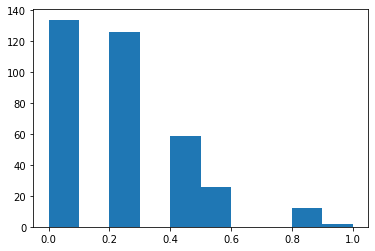

In [40]:
plt.hist(y_pred_test_)

In [ ]:
# Tests

In [ ]:
data_df_missing_count = data_df.isna().sum()
data_df_missing_count[data_df_missing_count > 100].sort_values(ascending = False)

In [ ]:
def train_test_split(data_df, labels_df, split_date):
    y_train = labels_df['Label'][labels_df['Date'] < split_date]
    y_test = labels_df['Label'][labels_df['Date'] >= split_date]
    
    X_train = data_df.loc[y_train.index]
    X_test = data_df.loc[y_test.index]
    
    print('X_train, y_train, X_test, y_test shapes: {}, {}, {}, {}'\
      .format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))
    
    return X_train, y_train, X_test, y_test

In [ ]:
X_train, y_train, X_test, y_test = train_test_split(data_df, labels_df, '2008-10-01')

In [ ]:
# Classification

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import metrics

In [ ]:
def classifier_comparison(X_train, y_train, X_test, y_test):
    names = ["Nearest Neighbors", "Decision Tree", "Random Forest", "Neural Net", "AdaBoost", "Gradient Boosting", "Naive Bayes", "QDA"]

    classifiers = [
        KNeighborsClassifier(),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        MLPClassifier(),
        AdaBoostClassifier(),
        GradientBoostingClassifier(),
        GaussianNB(),
        QuadraticDiscriminantAnalysis()]
    
    for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_train)
        fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred)
        print('{} train AUC: {}'.format(name, metrics.auc(fpr, tpr)))
        y_pred = clf.predict(X_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
        print('{} test AUC: {}\n'.format(name, metrics.auc(fpr, tpr)))

In [ ]:
# Imputation

In [ ]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy='mean')
imp = imp.fit(X_train)

X_train_imp = imp.transform(X_train)
X_test_imp = imp.transform(X_test)

In [ ]:
classifier_comparison(X_train_imp, y_train, X_test_imp, y_test)

In [ ]:
# SMOTE

In [ ]:
#!pip install imblearn

In [ ]:
from imblearn.over_sampling import SMOTE

smt = SMOTE()
X_train_imp_smt, y_train_smt = smt.fit_sample(X_train_imp, y_train)

In [ ]:
plt.subplot(1,2,1)
plt.hist(y_train)
plt.title('y_train')
plt.subplot(1,2,2)
plt.hist(y_train_smt)
plt.title('y_train_smt')
plt.tight_layout();

In [ ]:
classifier_comparison(X_train_imp_smt, y_train_smt, X_test_imp, y_test)

In [ ]:
#PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=0.97)
pca.fit(X_train_imp)  

print(pca.explained_variance_ratio_)  

In [ ]:
X_train_imp_pca = pca.transform(X_train_imp)
X_test_imp_pca = pca.transform(X_test_imp)
classifier_comparison(X_train_imp_pca, y_train, X_test_imp_pca, y_test)

In [ ]:
# Downsampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler(random_state=1)
X_train_imp_pca_sam, y_train_sam = ros.fit_sample(X_train_imp_pca, y_train)
plt.hist(y_train_sam);

In [ ]:
classifier_comparison(X_train_imp_pca_sam, y_train_sam, X_test_imp_pca, y_test)

In [ ]:
# Isolation forest

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, confusion_matrix

#classifier_comparison(X_train_imp_pca, y_train, X_test_imp_pca, y_test)
clf = IsolationForest(random_state=1, bootstrap = True, max_features =0.6)
clf.fit(X_train_imp)

# predictions
y_pred_train = clf.predict(X_train_imp)
y_pred_test = clf.predict(X_test_imp)

In [ ]:
y_pred_train = [1 if x < 0 else 0 for x in y_pred_train]
y_pred_test = [1 if x < 0 else 0 for x in y_pred_test]

name = 'Isolation Forest'
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_train)
precision = precision_score(y_train, y_pred_train)
recall = recall_score(y_train, y_pred_train)
print('{} train AUC: {:0.2f}'.format(name, metrics.auc(fpr, tpr)))
print('Train Precision: {:0.2f}. Train Recall: {:0.2f}\n'.format(precision, recall))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
print('{} test AUC: {:0.2f}'.format(name, metrics.auc(fpr, tpr)))
print('Test Precision: {:0.2f}. Test Recall: {:0.2f}'.format(precision, recall))

In [ ]:
confusion_matrix(y_test, y_pred_test)

In [ ]:
# PCA SMOTE

In [ ]:
pca_smt = PCA(n_components=0.97)
pca_smt.fit(X_train_imp_smt)  

print(pca_smt.explained_variance_ratio_)  

In [ ]:
X_train_imp_smt_pca = pca_smt.transform(X_train_imp_smt)
X_test_imp_pca = pca_smt.transform(X_test_imp)
classifier_comparison(X_train_imp_smt_pca, y_train_smt, X_test_imp_pca, y_test)

In [ ]:
name = 'Random Forest'
clf = RandomForestClassifier()
clf.fit(X_train_imp_sam, y_train_sam)
y_pred = clf.predict(X_train_imp_sam)
fpr, tpr, thresholds = metrics.roc_curve(y_train_sam, y_pred)
precision = precision_score(y_train_sam, y_pred)
recall = recall_score(y_train_sam, y_pred)
print('{} train AUC: {:0.2f}'.format(name, metrics.auc(fpr, tpr)))
print('Train Precision: {:0.2f}. Train Recall: {:0.2f}\n'.format(precision, recall))

y_pred = clf.predict(X_test_imp)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('{} test AUC: {:0.2f}'.format(name, metrics.auc(fpr, tpr)))
print('Test Precision: {:0.2f}. Train Recall: {:0.2f}'.format(precision, recall))

In [ ]:
name = 'Classifier'
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.ensemble import RUSBoostClassifier
clf = BalancedRandomForestClassifier(max_depth=2, random_state=0, max_features=0.6)

clf.fit(X_train_imp, y_train)
y_pred = clf.predict(X_train_imp)
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred)
precision = precision_score(y_train, y_pred)
recall = recall_score(y_train, y_pred)
print('{} train AUC: {:0.2f}'.format(name, metrics.auc(fpr, tpr)))
print('Train Precision: {:0.2f}. Train Recall: {:0.2f}\n'.format(precision, recall))

y_pred = clf.predict(X_test_imp)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('{} test AUC: {:0.2f}'.format(name, metrics.auc(fpr, tpr)))
print('Test Precision: {:0.2f}. Train Recall: {:0.2f}'.format(precision, recall))

In [ ]:
# Where –1 corresponds to a pass and 1 corresponds to a fail and the data time stamp is for that specific test point.
data = pd.read_csv("data/secom.data",  delimiter=' ', header=None, index_col=False)
target = pd.read_csv("data/secom_labels.data", header=None, index_col=False, delimiter=' ', usecols=[0])
data_size, feature_size = data.shape

'''pre processing steps'''

data = data.dropna(axis=1, thresh=int(2*data_size/4))
data_size, feature_size = data.shape
data = data.dropna(axis=0, thresh=int(2*feature_size/4))
imputer = preprocessing.Imputer(missing_values='NaN', strategy='median', axis=0)
target = np.asarray(target).reshape((data_size,))
data = np.asarray(data)
low_Var = VarianceThreshold(0.1)
scaler = preprocessing.StandardScaler()
pca = PCA(n_components=10,svd_solver='full')

''' customized accuracy scores '''


def tp_rate(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]/(confusion_matrix(y_true, y_pred)[0, 0] +
                                                                            confusion_matrix(y_true, y_pred)[0, 1])


def tn_rate(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]/(confusion_matrix(y_true, y_pred)[1, 1] +
                                                                            confusion_matrix(y_true, y_pred)[1, 0])


def BER(y_true, y_pred): return 1-(0.5*(confusion_matrix(y_true, y_pred)[0, 0]/(confusion_matrix(y_true, y_pred)[0, 0] +
                                                                                confusion_matrix(y_true, y_pred)[0, 1]) +
                                        confusion_matrix(y_true, y_pred)[1, 1] / (
                                        confusion_matrix(y_true, y_pred)[1, 1] +
                                        confusion_matrix(y_true, y_pred)[1, 0])))


clf = XGBClassifier(booster="gblinear", n_estimators=500)
kf = KFold(n_splits=10, shuffle=True, random_state=0)
tp = np.zeros(10)
ber = np.zeros(10)
tn = np.zeros(10)

In [ ]:
clf_R = RFE(estimator=svm.SVR(kernel='linear', C=1), n_features_to_select=40, step=1)
rfe = SelectFromModel(clf_R)
select_k = SelectKBest(k=40)                         # other option mutual_info_classif

In [ ]:
i = 0
for train_index, test_index in kf.split(data):
    data_train, data_test = data[train_index], data[test_index]
    target_train, target_test = target[train_index], target[test_index]
    data_train = imputer.fit_transform(data_train)
    ros = RandomUnderSampler(random_state=1)      # alternative ros = RandomOverSampler(random_state=1)
    data_train, target_train = ros.fit_sample(data_train, target_train)
    rfe = rfe.fit(data_train, target_train)
    pipeline = Pipeline(steps=[('impute', imputer),
                               ('var', low_Var),
                               ('scale', scaler),
                               ('FS', select_k),
                               ('clf', clf)])

    pipeline.fit(data_train, target_train)
    predict = pipeline.predict(data_test)
    ber[i] = BER(target_test, predict)
    tp[i] = tp_rate(target_test, predict)
    tn[i] = tn_rate(target_test, predict)
    i += 1

In [ ]:
print("TP: %0.2f (+/- %0.2f)" % (np.mean(tp),
                                  np.std(tp) * 2))
print("TN: %0.2f (+/- %0.2f)" % (np.mean(tn),
                                      np.std(tn) * 2))
print("BER: %0.2f (+/- %0.2f)" % (np.mean(ber),
                                     np.std(ber) * 2))